In [134]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [135]:
df = pd.read_csv("diabetes.csv", delimiter=",")

In [136]:
df.head(4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0


In [137]:
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [139]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [140]:
class ANN_Model(nn.Module):
  def __init__(self, input_features=8, hidden1=20, hidden2=20, hidden3=10, out_features=2):
    super().__init__()
    self.f_connected1 = nn.Linear(input_features, hidden1)
    self.f_connected2 = nn.Linear(hidden1, hidden2)
    self.f_connected3 = nn.Linear(hidden2, hidden3)
    self.out = nn.Linear(hidden3, out_features)

  def forward(self,x):
    x = F.relu(self.f_connected1(x))
    x = F.relu(self.f_connected2(x))
    x = F.relu(self.f_connected3(x))
    x = self.out(x)

    return x


In [141]:
model = ANN_Model()

In [142]:
model.parameters

<bound method Module.parameters of ANN_Model(
  (f_connected1): Linear(in_features=8, out_features=20, bias=True)
  (f_connected2): Linear(in_features=20, out_features=20, bias=True)
  (f_connected3): Linear(in_features=20, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=2, bias=True)
)>

In [143]:
loss_func = nn.CrossEntropyLoss()
lr = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [144]:
%%time
epochs = 500
final_losses = []

for i in range(epochs):
  i = i+1
  y_pred = model.forward(X_train)
  loss = loss_func(y_pred, y_train)
  final_losses.append(loss)

  if i%10==0:
    print("Epoch number: {} and the loss: {}".format(i, loss.item()))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch number: 10 and the loss: 0.6733523607254028
Epoch number: 20 and the loss: 0.5992828011512756
Epoch number: 30 and the loss: 0.556739091873169
Epoch number: 40 and the loss: 0.5456564426422119
Epoch number: 50 and the loss: 0.5236650109291077
Epoch number: 60 and the loss: 0.5051558017730713
Epoch number: 70 and the loss: 0.5103287696838379
Epoch number: 80 and the loss: 0.4905175268650055
Epoch number: 90 and the loss: 0.6686091423034668
Epoch number: 100 and the loss: 0.5019506216049194
Epoch number: 110 and the loss: 0.48831793665885925
Epoch number: 120 and the loss: 0.4783214330673218
Epoch number: 130 and the loss: 0.47032827138900757
Epoch number: 140 and the loss: 0.46393007040023804
Epoch number: 150 and the loss: 0.46033376455307007
Epoch number: 160 and the loss: 0.456987202167511
Epoch number: 170 and the loss: 0.4535571038722992
Epoch number: 180 and the loss: 0.4553033709526062
Epoch number: 190 and the loss: 0.46543416380882263
Epoch number: 200 and the loss: 0.454

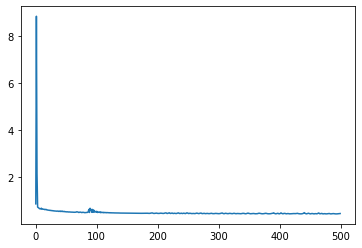

In [145]:
n_epochs = range(epochs)
plt.plot(n_epochs, final_losses);

In [146]:
## Predict in Test data
predictions = [] 
with torch.no_grad():
  for i, data in enumerate(X_test):
    pred = model(data)
    f_pred = pred.argmax().item()
    predictions.append(f_pred)

In [147]:
cm = confusion_matrix(y_test, predictions)
cm

array([[89, 18],
       [12, 35]])

Text(69.0, 0.5, 'Prediction')

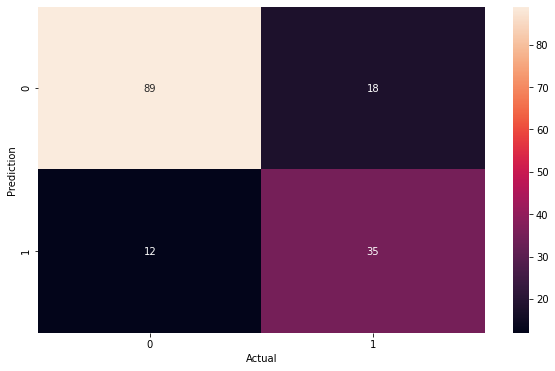

In [148]:
plt.figure(figsize=(10,6))

sns.heatmap(cm, annot=True)
plt.xlabel("Actual")
plt.ylabel("Prediction")

In [149]:
score = accuracy_score(y_test, predictions)
score

0.8051948051948052

In [150]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       107
           1       0.66      0.74      0.70        47

    accuracy                           0.81       154
   macro avg       0.77      0.79      0.78       154
weighted avg       0.81      0.81      0.81       154



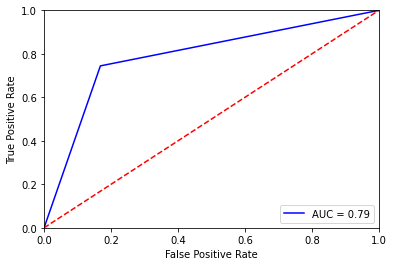

In [151]:
fpr, tpr, threshold = roc_curve(y_test, predictions)

roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [152]:
## Predict in new data
list(df.iloc[0,:-1])

[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0]

In [153]:
lst = [6.0, 130.0, 72.0, 55.0, 0.0, 29.6, 0.627, 40.0]  

In [154]:
new_data = torch.Tensor(lst)

In [155]:
with torch.no_grad():
    pred = model(new_data)
    f_pred = pred.argmax().item()
    
f_pred

1

In [156]:
### Save the Model
torch.save(model, "diabetes.pt")